In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

import wandb
from wandb.integration.keras import WandbMetricsLogger

## **Initial Setup and Justification**
 **Approach:**
- Use transfer learning for robust feature extraction (e.g., a pre-trained model like `MobileNetV2`)
- Perform image augmentation to enrich the dataset and reduce overfitting
- Evaluate the model using accuracy, precision, recall, and F1-score
**Justification:**
- Transfer learning leverages the hierarchical feature extraction capability of pre-trained networks
- Data augmentation enhances the diversity of the dataset, reducing overfitting

**Pros:**
- Faster convergence due to pre-trained weights
- Reduced need for extensive labeled data

**Cons:**
- Pre-trained models may introduce bias from their training data
- Transfer learning might not perfectly align with the trash classification domain


# Explaratory Image Analysis

In [2]:
base_dir = os.path.expanduser('dataset-resized')

See the sample images from each categories

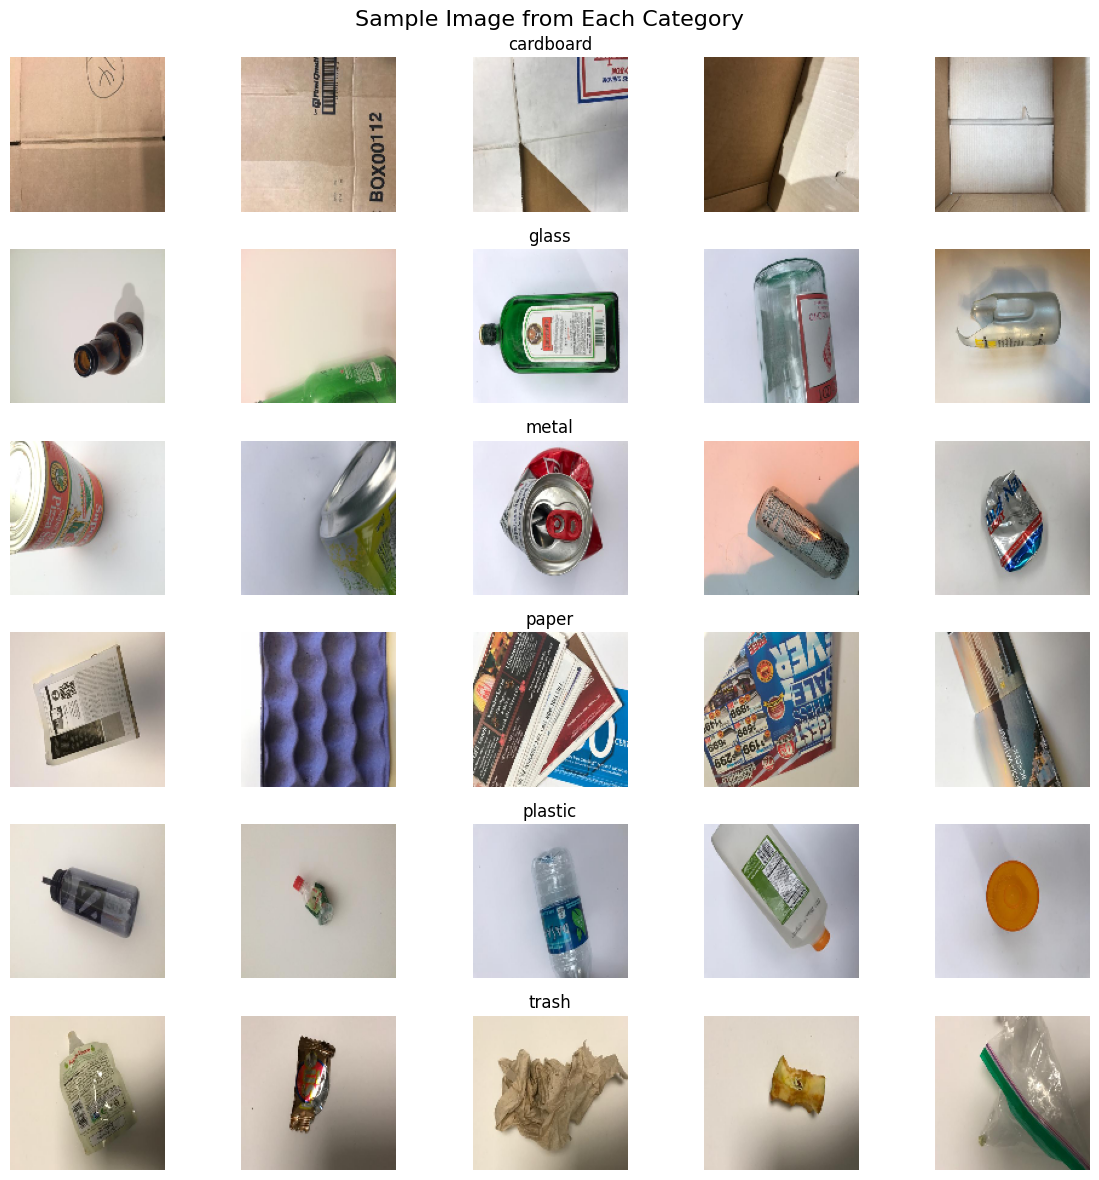

In [3]:
categories = ['cardboard','glass','metal','paper','plastic','trash']

n_sample = 5

fig, axes = plt.subplots(nrows=len(categories), ncols=n_sample, figsize=(12, 12))
fig.suptitle("Sample Image from Each Category", fontsize=16)

for i, category in enumerate(categories):
    category_dir = os.path.join(base_dir, category)
    images = os.listdir(category_dir)[:n_sample]
    for j, img in enumerate(images):
        img_path = os.path.join(category_dir, img)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 2:
            axes[i, j].set_title(category)

plt.tight_layout()
plt.show()

See the number images  per category 

In [4]:
cat_counts = {}

for category in categories:
    cat_dir = os.path.join(base_dir, category)
    num_images = len([file for file in os.listdir(cat_dir) if os.path.isfile(os.path.join(cat_dir, file))])
    cat_counts[category] = num_images

print(cat_counts)

{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}


It seems that `trash` category has the smallest proportion compared to the other categories

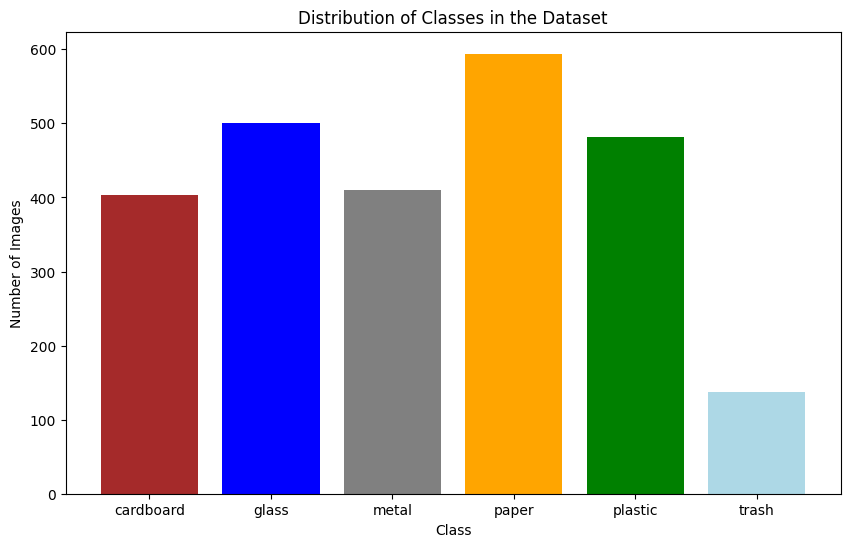

In [5]:
# Create lists for the classes and their respective counts
cat_names = list(cat_counts.keys())
counts = list(cat_counts.values())

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(cat_names, counts, color=['brown', 'blue', 'grey','orange','green','lightblue'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in the Dataset')
plt.show()

### Create Data Generator

The data generator is created with a data augmentation, in thery it will help the model to generalize properly in the presence of limited training dataset. The training and validation dataset is splitted with 75% and 25% proportion

In [6]:
# Parameters for data generators
image_size = (224, 224)
batch_size = 32


In [7]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1898 images belonging to 6 classes.
Found 629 images belonging to 6 classes.


In [9]:
train_generator.samples, train_generator.batch_size

(1898, 32)

In [10]:
val_generator.samples, val_generator.batch_size

(629, 32)

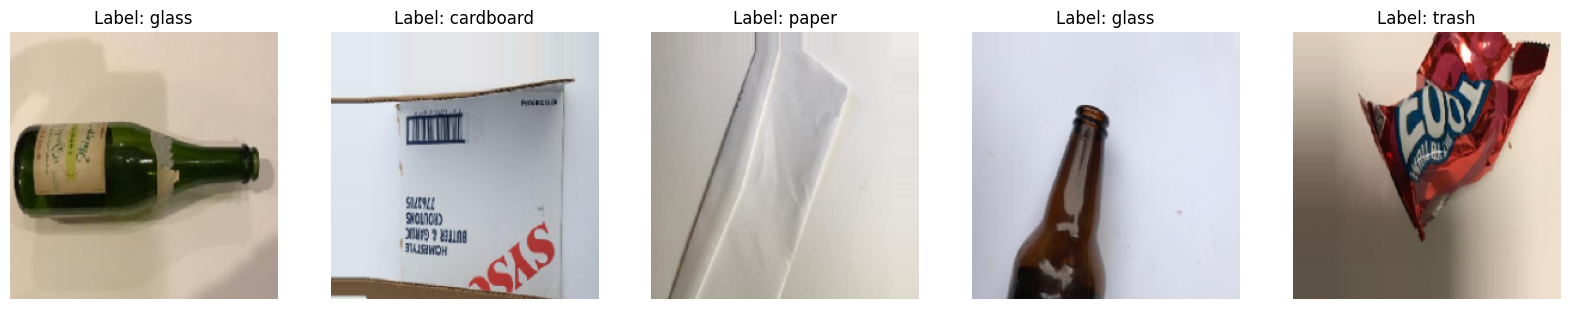

In [11]:
# Visualize sample images
class_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

# Use Python's next() function to get a batch from the generator
batch = next(train_generator)

# Access images and labels from the batch
images, labels = batch

# Display the first 5 images and their labels
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Label: {class_labels[np.argmax(labels[i])]}")
    ax.axis('off')

plt.show()


## Model Experimentation

In [12]:
n_class = len(train_generator.class_indices)
print(n_class)

6


The experiment is traced using Weight and Biases. All the logs created from the training process can be seen in this [workspace](https://wandb.ai/mhilmisyarif/trash-classification?nw=nwusermhilmisyarif)

In [13]:
# Initialize WandB
run = wandb.init(
    project="trash-classification", 
    config={
        "learning_rate": 2e-5,
        "loss": "categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 20,
    }
)

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mhilmisyarif. Use `wandb login --relogin` to force relogin


In [14]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
output = Dense(n_class, activation='softmax')(x)

# Compile model
model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=config.loss,
    metrics=[config.metric]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,624,710 (10.01 MB)

 Trainable params: 2,219,270 (8.47 MB)

 Non-trainable params: 405,440 (1.55 MB)

### Architecture explanation
This architecture appears to use MobileNetV2 as the base model for feature extraction, followed by additional layers to fine-tune it for a custom classification task with 6 classes.

Main model's block:
- **Feature Extractor: MobileNetV2**
    - Pre-trained MobileNetV2 reduces input images to a compact feature map (2x2x1280).
    - Earlier layers are freezed to retain pre-trained weights.

Add last customer layer to fine-tuned the model:
- **Global Average Pooling**
    - The use of GlobalAveragePooling2D reduces the size of the dense layers, lowering the overall parameter count.
- **Batch Normalization**
    -  Normalizes the output of the previous layer, which helps in stabilizing and speeding up the training.


In [15]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=config.epoch,
    callbacks=[early_stopping, WandbMetricsLogger()]
)

# Save the model locally
path = "./model/trash-classification-mobilenetv2-finetuned.keras"
weight_path = "./model/trash-classification-mobilenetv2-finetuned.weights.h5"
model.save(path)
model.save_weights(weight_path)

# Save model to W&B
path = "./model/trash-classification-mobilenetv2-finetuned.keras"
registered_model_name = "trash-classification"

run.link_model(path=path, registered_model_name=registered_model_name)

print(f"The model hsa been trained and saved in W&B '{path}'")

wandb.finish()

d:\src\projects\trash-classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.1684 - loss: 3.4093 - val_accuracy: 0.1924 - val_loss: 1.9004
Epoch 2/20
 1/59 ━━━━━━━━━━━━━━━━━━━━ 43s 747ms/step - accuracy: 0.1562 - loss: 3.3824

d:\src\projects\trash-classification\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.1562 - loss: 3.3824 - val_accuracy: 0.1990 - val_loss: 1.8934
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.2017 - loss: 3.2039 - val_accuracy: 0.3109 - val_loss: 1.7281
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.2188 - loss: 2.8659 - val_accuracy: 0.3191 - val_loss: 1.7179
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.2608 - loss: 2.6167 - val_accuracy: 0.3931 - val_loss: 1.5788
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.3438 - loss: 2.2855 - val_accuracy: 0.4178 - val_loss: 1.5512
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2821 - loss: 2.5654 - val_accuracy: 0.4622 - val_loss: 1.4257
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.3125 - loss: 2.3973 - val_accuracy: 0.4589 - val_loss: 1.4121
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3348 - loss: 2.3060 - val_accuracy: 0.4786 - val_loss

epoch/accuracy,▁▁▂▂▃▄▃▄▄▅▅▄▅▆▆█▆▅▆▅
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▅▄▅▄▄▃▄▃▃▂▂▁▂▂▂▂
epoch/val_accuracy,▁▁▃▃▅▅▆▆▆▇▇▇▇▇██████
epoch/val_loss,██▆▆▅▅▄▄▃▃▂▂▂▂▁▂▁▁▁▁
epoch/accuracy,0.40625
epoch/epoch,19
epoch/learning_rate,2e-05
epoch/loss,1.68931
epoch/val_accuracy,0.55592


See the model performance


In [17]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 742ms/step - accuracy: 0.5859 - loss: 1.0609
Validation Loss: 1.1160948276519775, Validation Accuracy: 0.5771065354347229


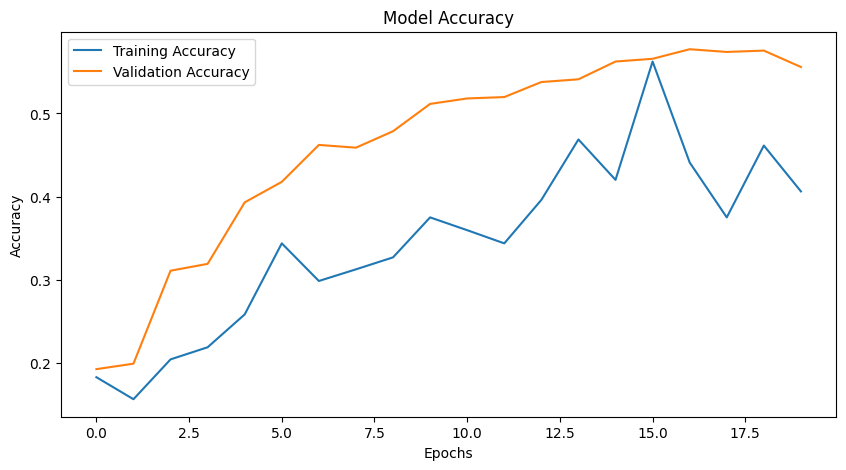

In [18]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Push Model to Huggingface Hub

In [21]:
from huggingface_hub import HfApi

api = HfApi()

api.upload_file(
    path_or_fileobj="./model/trash-classification-mobilenetv2-finetuned.keras",
    path_in_repo="trash-classification-mobilenetv2-finetuned.keras",
    repo_id="hilmisyarif/trash-classification-mobilenetv2-finetuned",
    repo_type="model"
    
)

CommitInfo(commit_url='https://huggingface.co/hilmisyarif/trash-classification-mobilenetv2-finetuned/commit/7869afa7c54821cceba2de5f64d5793e1409283e', commit_message='Upload trash-classification-mobilenetv2-finetuned.keras with huggingface_hub', commit_description='', oid='7869afa7c54821cceba2de5f64d5793e1409283e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hilmisyarif/trash-classification-mobilenetv2-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='hilmisyarif/trash-classification-mobilenetv2-finetuned'), pr_revision=None, pr_num=None)

In [22]:
api.upload_file(
    path_or_fileobj="./model/trash-classification-mobilenetv2-finetuned.weights.h5",
    path_in_repo="trash-classification-mobilenetv2-finetuned.weights.h5",
    repo_id="hilmisyarif/trash-classification-mobilenetv2-finetuned",
    repo_type="model"
)

CommitInfo(commit_url='https://huggingface.co/hilmisyarif/trash-classification-mobilenetv2-finetuned/commit/a92a14f25be35a96579fce499ecc579138989e69', commit_message='Upload trash-classification-mobilenetv2-finetuned.weights.h5 with huggingface_hub', commit_description='', oid='a92a14f25be35a96579fce499ecc579138989e69', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hilmisyarif/trash-classification-mobilenetv2-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='hilmisyarif/trash-classification-mobilenetv2-finetuned'), pr_revision=None, pr_num=None)